In [102]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать 
 их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 
   Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [103]:
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_redundant=0, n_classes=2, random_state=1)

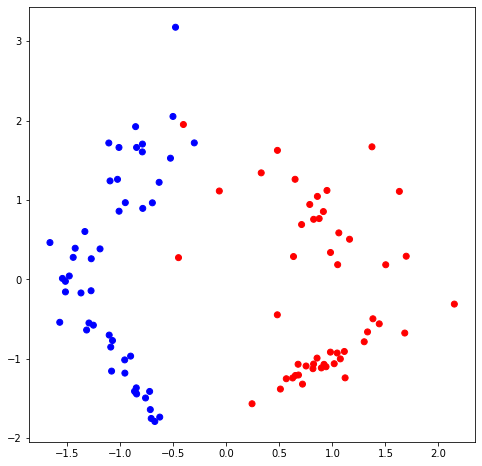

In [104]:
c_map = ListedColormap(['blue', 'red'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)),
            list(map(lambda x: x[1], classification_data)), c = classification_labels, cmap=c_map)

In [105]:
class Leaf():
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        samples = {}
        for label in self.labels:
            if label not in samples:
                samples[label] = 0
            samples[label] += 1
        prediction = max(samples, key=samples.get)
        return prediction

In [106]:
class Node():
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [107]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [108]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [109]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    impurity = 1
    for label in classes:
        p = classes[label]/len(labels)
        impurity -= p**2
    
    return impurity

In [110]:
def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0])/(left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p*gini(left_labels) - (1-p)*gini(right_labels)

In [111]:
def split(index, t, data, labels):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    
    true_data = data[left]
    true_labels = labels[left]
    false_data = data[right]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [112]:
def find_best_split(data, labels):
    
    min_leaf = 1
    
    current_gini = gini(labels)
    
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(index, t, data, labels)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
        
    return best_quality, best_t, best_index

In [113]:
def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    
    if quality == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(index, t, data, labels)
    
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    
    return Node(index, t, true_branch, false_branch)

In [114]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [115]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [116]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [117]:
def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [118]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                     classification_labels, 
                                                                     test_size = 0.3,
                                                                     random_state = 1)

In [127]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [119]:
forest_1 = random_forest(train_data, train_labels, 1)

In [128]:
train_answers_1 = tree_vote(forest_1, train_data)
test_answers_1 = tree_vote(forest_1, test_data)

In [129]:
accuracy_metric(train_labels, train_answers_1), accuracy_metric(test_labels, test_answers_1)

(100.0, 93.33333333333333)

In [120]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

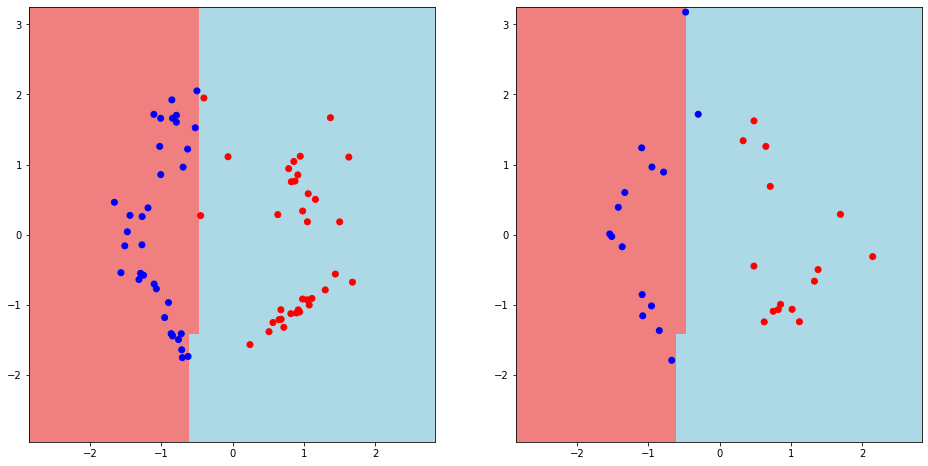

In [132]:
light_colors = ListedColormap(['lightcoral', 'lightblue'])

xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], train_data)),
            list(map(lambda x: x[1], train_data)), c = train_labels, cmap=c_map)

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], test_data)),
            list(map(lambda x: x[1], test_data)), c = test_labels, cmap=c_map)

In [124]:
forest_3 = random_forest(train_data, train_labels, 3)

In [134]:
train_answers_3 = tree_vote(forest_3, train_data)
test_answers_3 = tree_vote(forest_3, test_data)

In [135]:
accuracy_metric(train_labels, train_answers_3), accuracy_metric(test_labels, test_answers_3)

(100.0, 93.33333333333333)

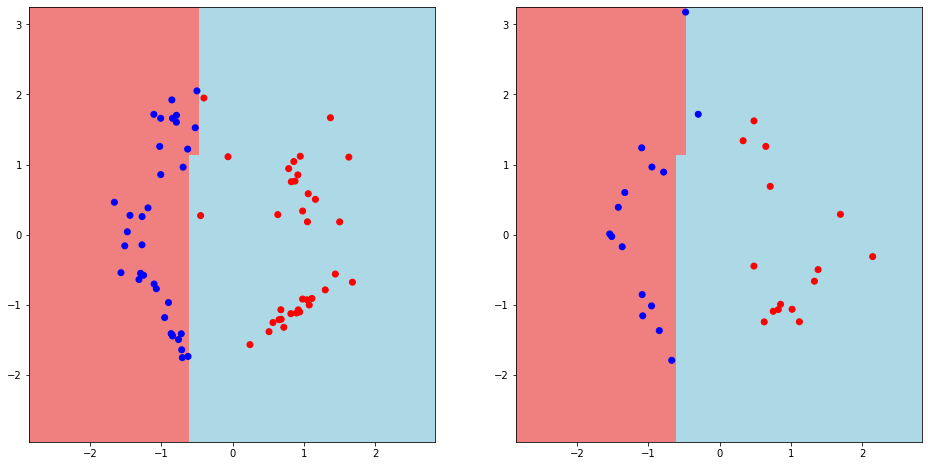

In [133]:
mesh_predictions = np.array(tree_vote(forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)


plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], train_data)),
            list(map(lambda x: x[1], train_data)), c = train_labels, cmap=c_map)

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], test_data)),
            list(map(lambda x: x[1], test_data)), c = test_labels, cmap=c_map)

In [126]:
forest_10 = random_forest(train_data, train_labels, 10)

In [136]:
train_answers_10 = tree_vote(forest_10, train_data)
test_answers_10 = tree_vote(forest_10, test_data)

In [137]:
accuracy_metric(train_labels, train_answers_10), accuracy_metric(test_labels, test_answers_10)

(100.0, 93.33333333333333)

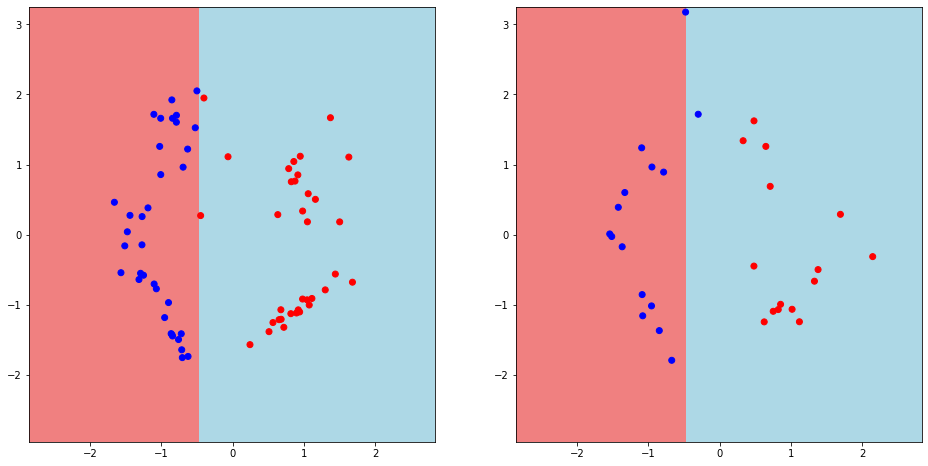

In [138]:
mesh_predictions = np.array(tree_vote(forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)


plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], train_data)),
            list(map(lambda x: x[1], train_data)), c = train_labels, cmap=c_map)

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], test_data)),
            list(map(lambda x: x[1], test_data)), c = test_labels, cmap=c_map)

In [139]:
forest_50 = random_forest(train_data, train_labels, 50)

In [140]:
train_answers_50 = tree_vote(forest_50, train_data)
test_answers_50 = tree_vote(forest_50, test_data)

In [141]:
accuracy_metric(train_labels, train_answers_50), accuracy_metric(test_labels, test_answers_50)

(100.0, 93.33333333333333)

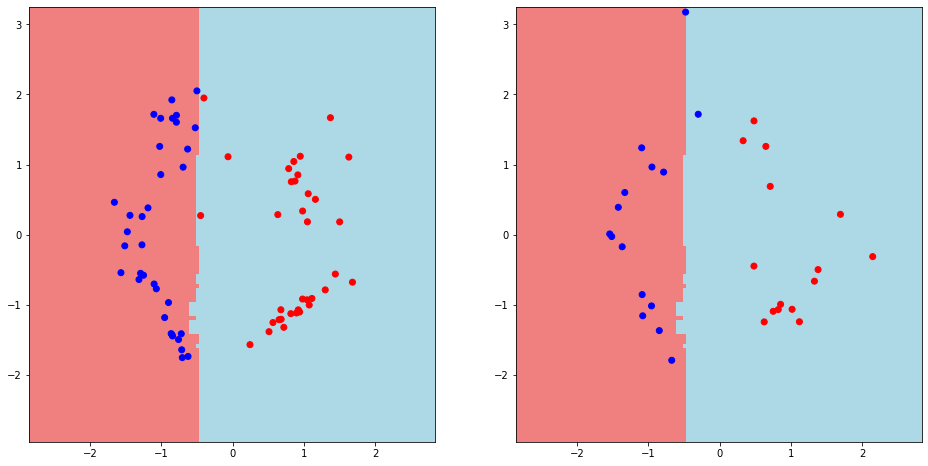

In [142]:
mesh_predictions = np.array(tree_vote(forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)


plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], train_data)),
            list(map(lambda x: x[1], train_data)), c = train_labels, cmap=c_map)

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(list(map(lambda x: x[0], test_data)),
            list(map(lambda x: x[1], test_data)), c = test_labels, cmap=c_map)

Вывод: чем больше деревьев учавствует в голосовании, тем сложнее получается гиперплоскоть. Соответственно малое количество деревьев может вести к недообучению, а слишком большое к переобучению.

2*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [158]:
def data_in_tree(node, data):
    
    if isinstance(node, Leaf):
        if data in node.data:
            return True
        else:
            return False
    
    if data[node.index] <= node.t:
        return data_in_tree(node.true_branch, data)
    else:
        return data_in_tree(node.false_branch, data)

In [187]:
def out_of_bag_error(forest, data, labels):
    accuracy = []
    for index, row in enumerate(data):
        classes = []
        for tree in forest:
            if not data_in_tree(tree, row):
                prediction = predict([row], tree)[0]
                classes.append(prediction)
        voted_prediction = max(set(classes), key=classes.count)
        accuracy.append(accuracy_metric([labels[index]], [voted_prediction]))
    
    return np.mean(accuracy)

In [188]:
out_of_bag_error(forest_50, train_data, train_labels)

98.57142857142857

3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [152]:
def calc_entropy(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 0
    for item in classes:
        p = classes[item]/len(labels)
        if p == 0:
            continue
        impurity -= p*np.log2(p)
    
    return impurity

In [153]:
calc_entropy(classification_labels)

1.0